In [127]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [128]:
import numpy as np
import pandas as pd

In [129]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [130]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [131]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [132]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [133]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [134]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [135]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [136]:
#Starting to create a session from Python to DB
session.query(Measurement).limit(2).all()

# Exploratory Climate Analysis

In [137]:
#trying to figure out how our table looks like what types of datatype I'm dealing with
Station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [138]:
#getting a starter point on last year date
for date in last_date:
    split_last_date=date.split('-')
    
split_last_date
year=int(split_last_date[0]); last_month=int(split_last_date[1]); last_day=int(split_last_date[2])

In [139]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(year, last_month, last_day) - dt.timedelta(days=365)
print(query_date)

2016-08-23


In [140]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
#group_by(Measurement.date).all()
#precipitation


In [141]:
precipittion=session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date>=query_date).\
order_by(Measurement.date).all()

In [142]:
# Save the query results as a Pandas DataFrame and set the index to the date column
weather=pd.DataFrame(precipittion,columns=['date', 'prcp'])
weather.set_index('date', inplace=True)


In [143]:
weather.head(11)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


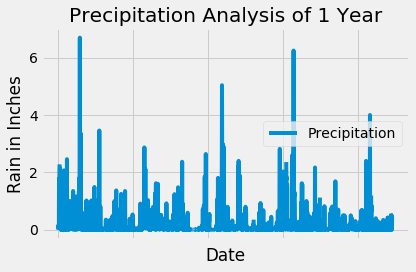

In [145]:
weather.plot()
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis of 1 Year")
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()

In [146]:
# Use Pandas to calcualte the summary statistics for the precipitation data
weather.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [147]:
# Design a query to show how many stations are available in this dataset?
stations=session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are: {stations} stations available")

There are: 9 stations available


In [148]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station). \
order_by(func.count(Measurement.station).desc()).all()

In [149]:
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [150]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
low_temp = [Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]

max_temp=session.query(*low_temp).group_by(Measurement.station). \
order_by(func.count(Measurement.station).desc()).first()

In [151]:
#now that we have run the query let see what is the max temperature active
max_temp

('USC00519281', 54.0, 85.0, 71.66378066378067)

In [152]:
# Choose the station with the highest number of temperature observations.

station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
station= station[0]


In [153]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observations = session.query( Measurement.tobs).filter(Measurement.date >= last_year).filter(Measurement.station == station).all()
observations = pd.DataFrame(observations, columns=['temperature'])

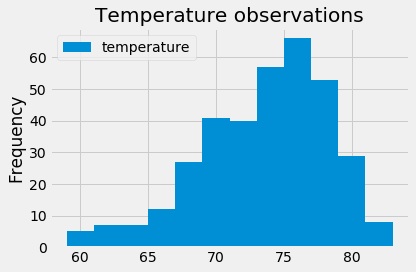

In [154]:
#Creating an histogram for that hold 12 months of temperature
observations.plot.hist(bins=12, title="Temperature observations")
plt.tight_layout()
plt.savefig("Images/TemperaturevsFrequency.png")
plt.show()

In [155]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [156]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temperature=calc_temps('2017-08-08', '2017-08-18')
temperature

[(70.0, 78.24444444444444, 84.0)]

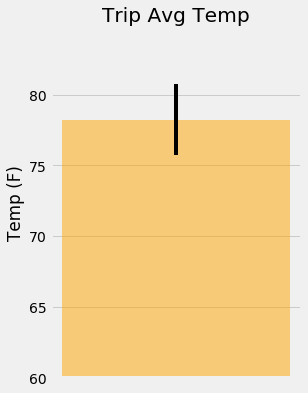

In [157]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
low = temperature[0][1] -temperature[0][0]
up = temperature[0][2] - temperature[0][1]

plt.figure(figsize=(4,6))
plt.bar(0, temperature[0][1], yerr=[up-low], color='orange', alpha=0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(60)

plt.show()

In [158]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def rainfall(start_date, end_date):
    return session.query(Measurement.station, 
                         Measurement.prcp.label('rainfall'),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by('rainfall DESC').all()

rainfall('2017-08-08', '2017-08-18')

C:\Users\francis\AppData\Local\Continuum\anaconda3\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'rainfall DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[('USC00516128', 0.34, 21.3331, -157.8025, 152.4),
 ('USC00514830', 0.1, 21.5213, -157.8374, 7.0),
 ('USC00519281', 0.0, 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0, 21.33556, -157.71139, 19.5)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


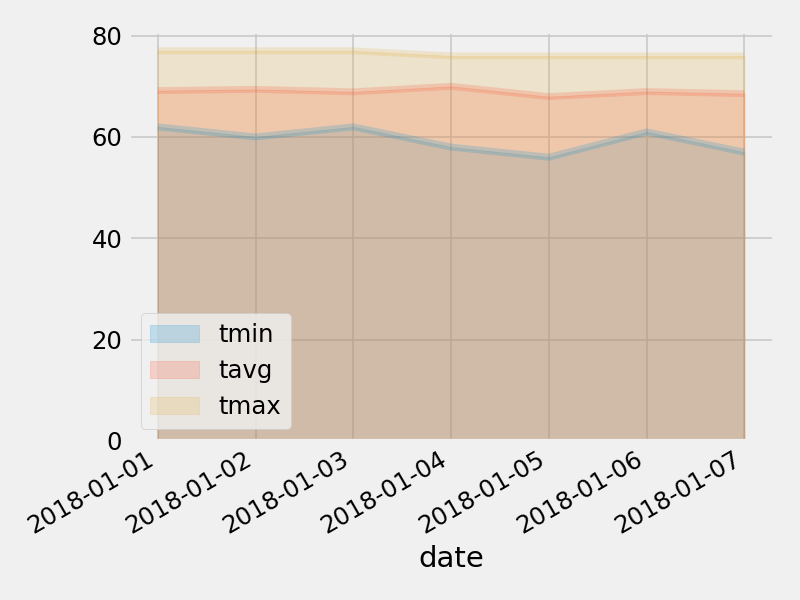

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
